In [1]:
import os
import cv2
import numpy as np
import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from tqdm import tqdm
from IPython.display import display
pd.set_option('display.max_columns', None)


In [3]:
'''Face detection'''
'''Loading Face and Landmark Detectors'''


# Load the face detector and the shape predictor (facial landmarks model)
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('dlib/shape_predictor_68_face_landmarks.dat') # Download this file from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

# Image paths from folder
image_paths = [os.path.join('sample_images',x) for x in os.listdir('sample_images')]

#init dataframe to save bounding boxes
col = ['image', 'C_R_1', 'C_R_2', 'C_L_1', 'C_L_2', 'F_1', 'F_2']
df = pd.DataFrame(columns=col)

for i,image_path in enumerate(image_paths):
    image = dlib.load_rgb_image(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale for processing
    
    # Detect faces in the image
    faces = face_detector(gray)
    error = []
    CA = 0
    A = 2000 #pixels

    # Loop through detected faces and extract landmarks
    for face in faces:
        # Get facial landmarks
        landmarks = landmark_predictor(gray, face)
        
        shape = landmark_predictor(gray, face)
        cordinates = []
        for l in range(68):
            
            cordinates.append([shape.part(l).x, shape.part(l).y])
            
        #bounding boxes
        #dlib landmark points: https://i0.wp.com/sefiks.com/wp-content/uploads/2020/11/Face-Landmark-Representation.png?ssl=1
        # (x1_x,y1_x) = top left for x patch
        # (x2_x,y2_x) = bottom right for x patch

        #Right Cheek
        x1_r = int(cordinates[55][0]+(cordinates[15][0]-cordinates[10][0])/2) 
        x2_r = int(cordinates[16][0]-((cordinates[16][0]-cordinates[12][0])/3)) 
        y1_r = cordinates[29][1]
        y2_r = cordinates[53][1] 

        #Left Cheek   
        x1_l = int(cordinates[2][0]+((cordinates[6][0]-cordinates[2][0])/4)) 
        x2_l = int(cordinates[49][0]-(cordinates[6][0]-cordinates[4][0])/1.5) 
        y1_l = cordinates[29][1]
        y2_l = cordinates[60][1]

        #forheah
        x1_f = cordinates[19][0]
        x2_f = cordinates[24][0]
        f1 = cordinates[20][1]
        f2 = cordinates[25][1]

        if f1>f2:
            y2_f = f1
        else:
            y2_f = f2

        y1_f = y2_f - int((x2_f-x1_f)/2.5)
        y2_f = y2_f + int((y1_f-y2_f)/3)
            
        #append to df
        df.loc[len(df.index)] = {'image':image_path, 'C_R_1':(x1_r,y1_r), 
                                'C_R_2':(x2_r,y2_r), 'C_L_1':(x1_l,y1_l), 
                                'C_L_2':(x2_l,y2_l), 'F_1':(x1_f,y1_f), 'F_2':(x2_f,y2_f)}
        


In [4]:
df

,image,C_R_1,C_R_2,C_L_1,C_L_2,F_1,F_2
0,sample_images/Keivan_Bahmani.jpg,"(474, 412)","(544, 528)","(225, 412)","(296, 522)","(303, 234)","(498, 286)"
1,sample_images/Mahesh_Banavar.jpg,"(368, 367)","(429, 432)","(184, 367)","(226, 439)","(227, 235)","(361, 271)"
2,sample_images/Schuckers_Stephanie.jpg,"(1103, 1112)","(1252, 1314)","(539, 1112)","(673, 1339)","(681, 714)","(1098, 825)"


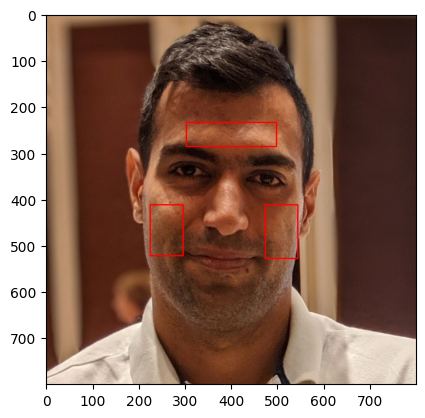

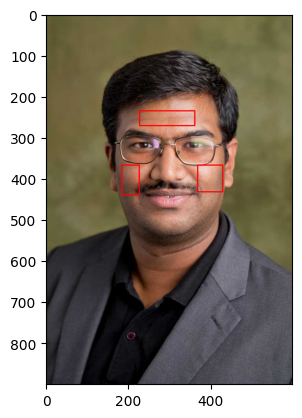

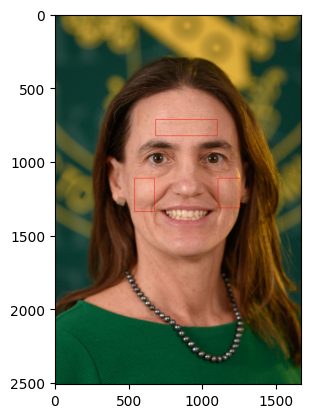

In [5]:
'''Print for debugging'''

#bool to visualize the landmarked bounding boxes
visualizeBB = True
numVisualizations = 3

if visualizeBB:
    for i in range(0,numVisualizations):
        plt.figure()
        img = cv2.imread(df.iloc[i,:].image)
        imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #RGB color image

        imgc = cv2.rectangle(imgc, df.iloc[i,:].C_R_1, df.iloc[i,:].C_R_2, color = (255,0,0), thickness=2, lineType=8, shift=0)
        imgc = cv2.rectangle(imgc, df.iloc[i,:].C_L_1, df.iloc[i,:].C_L_2, color = (255,0,0), thickness=2, lineType=8, shift=0)
        imgc = cv2.rectangle(imgc, df.iloc[i,:].F_1,  df.iloc[i,:].F_2, color = (255,0,0), thickness=2, lineType=8, shift=0)
        plt.imshow(imgc)

In [25]:
'''Reflectance Extraction using NNMF Decomposition'''

W_list_R = [] #W matrix for each sample
H_list_R = [] #H matrix for each sample
S_list_R = [] #Either 0 or 1 shows the selected dimension for the specular 
Sum_S_R  = [] #sum of the reflectance weights
Sum_D_R  = [] # sum of the diffuse weights
Reflectance_Index_R = []

W_list_L = [] #W matrix for each sample
H_list_L = [] #H matrix for each sample
S_list_L = [] #Either 0 or 1 shows the selected dimension for the specular 
Sum_S_L  = [] #sum of the reflectance weights
Sum_D_L  = [] # sum of the diffuse weights
Reflectance_Index_L = []

W_list_F = [] #W matrix for each sample
H_list_F = [] #H matrix for each sample
S_list_F = [] #Either 0 or 1 shows the selected dimension for the specular 
Sum_S_F  = [] #sum of the reflectance weights
Sum_D_F  = [] # sum of the diffuse weights
Reflectance_Index_F = []


W_list_A = [] #W matrix for each sample
H_list_A = [] #H matrix for each sample
S_list_A = [] #Either 0 or 1 shows the selected dimension for the specular 
Sum_S_A  = [] #sum of the reflectance weights
Sum_D_A  = [] # sum of the diffuse weights
Reflectance_Index_A = []
Errors = []



for i in tqdm(range(len(df))):
    file = df.iloc[i,:].image
    img = cv2.imread(file)
    imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #RGB color imag
    try:
        cropped_F = imgc[df.iloc[i,:].F_1[1]:df.iloc[i,:].F_2[1], 
                     df.iloc[i,:].F_1[0]:df.iloc[i,:].F_2[0]]
        f_array = np.squeeze(np.reshape(cropped_F,(1,-1,3)))
        
        P_F = np.average(np.average(cropped_F, axis=0), axis=0)

        
        '''Forehead'''
        model = NMF(n_components=2, init='nndsvda', tol=5e-3, l1_ratio=0.2)
        W = model.fit_transform(f_array)
        comp = model.components_
        #Images_NFM = np.reshape(W,(cropped_F.shape[0],cropped_F.shape[1],2))
        s_f = np.argmax(np.sum(comp, axis=1))
        sum_s = np.sum(W[:,s_f]) # reflectance has higher sum
        if s_f == 1:
            sum_d = np.sum(W[:,0])
        elif s_f == 0:
            sum_d = np.sum(W[:,1])
        W_list_F.append(W)
        H_list_F.append(comp)
        S_list_F.append(s_f)
        Sum_S_F.append(sum_s)
        Sum_D_F.append(sum_d)
        Reflectance_Index_F.append(sum_s/(sum_s+sum_d))
        
    except:
        W_list_F.append(np.nan)
        H_list_F.append(np.nan)
        S_list_F.append(np.nan)
        Sum_S_F.append(np.nan)
        Sum_D_F.append(np.nan)
        Reflectance_Index_F.append(np.nan)
        
    try:   
        cropped_R = imgc[df.iloc[i,:].C_R_1[1]:df.iloc[i,:].C_R_2[1], 
                     df.iloc[i,:].C_R_1[0]:df.iloc[i,:].C_R_2[0]]
        R_array = np.squeeze(np.reshape(cropped_R,(1,-1,3)))
        P_R = np.average(np.average(cropped_R, axis=0), axis=0)
  
           
        '''Right'''
        model = NMF(n_components=2, init='nndsvda', tol=5e-3, l1_ratio=0.2)
        W = model.fit_transform(R_array)
        comp = model.components_
        #Images_NFM = np.reshape(W,(cropped_F.shape[0],cropped_F.shape[1],2))
        s_r = np.argmax(np.sum(comp, axis=1))
        sum_s = np.sum(W[:,s_r]) # reflectance has higher sum
        if s_r == 1:
            sum_d = np.sum(W[:,0])
        elif s_r == 0:
            sum_d = np.sum(W[:,1])
        W_list_R.append(W)
        H_list_R.append(comp)
        S_list_R.append(s_r)
        Sum_S_R.append(sum_s)
        Sum_D_R.append(sum_d)
        Reflectance_Index_R.append(sum_s/(sum_s+sum_d))    
        
    except:
        W_list_R.append(np.nan)
        H_list_R.append(np.nan)
        S_list_R.append(np.nan)
        Sum_S_R.append(np.nan)
        Sum_D_R.append(np.nan)
        Reflectance_Index_R.append(np.nan)       
        

    try:    
        cropped_L = imgc[df.iloc[i,:].C_L_1[1]:df.iloc[i,:].C_L_2[1], 
                     df.iloc[i,:].C_L_1[0]:df.iloc[i,:].C_L_2[0]]
        L_array = np.squeeze(np.reshape(cropped_L,(1,-1,3)))
        P_L = np.average(np.average(cropped_L, axis=0), axis=0)

    
        '''LEFT'''
        model = NMF(n_components=2, init='nndsvda', tol=5e-3, l1_ratio=0.2)
        W = model.fit_transform(L_array)
        comp = model.components_
        #Images_NFM = np.reshape(W,(cropped_F.shape[0],cropped_F.shape[1],2))
        s_l = np.argmax(np.sum(comp, axis=1))
        sum_s = np.sum(W[:,s_l]) # reflectance has higher sum
        if s_l == 1:
            sum_d = np.sum(W[:,0])
        elif s_l == 0:
            sum_d = np.sum(W[:,1])
        W_list_L.append(W)
        H_list_L.append(comp)
        S_list_L.append(s_l)
        Sum_S_L.append(sum_s)
        Sum_D_L.append(sum_d)
        Reflectance_Index_L.append(sum_s/(sum_s+sum_d))

    except:
        W_list_L.append(np.nan)
        H_list_L.append(np.nan)
        S_list_L.append(np.nan)
        Sum_S_L.append(np.nan)
        Sum_D_L.append(np.nan)
        Reflectance_Index_L.append(np.nan)
        Errors.append(i)
        
        
df['W_list_F'] = W_list_F
df['H_list_F'] = H_list_F
df['S_list_F'] = S_list_F
df['Sum_S_F']  = Sum_S_F
df['Sum_D_F']  = Sum_D_F
df['Reflectance_Index_F'] = Reflectance_Index_F

df['W_list_R'] = W_list_R
df['H_list_R'] = H_list_R
df['S_list_R'] = S_list_R
df['Sum_S_R']  = Sum_S_R
df['Sum_D_R']  = Sum_D_R
df['Reflectance_Index_R'] = Reflectance_Index_R

df['W_list_L'] = W_list_L
df['H_list_L'] = H_list_L 
df['S_list_L'] = S_list_L
df['Sum_S_L']  = Sum_S_L
df['Sum_D_L']  = Sum_D_L
df['Reflectance_Index_L'] = Reflectance_Index_L

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 36.93it/s]


In [26]:
'''how many errors in the adaptive'''
len(Errors)

0

In [27]:
df = df.dropna(subset= ['S_list_F', 'S_list_L', 'S_list_R'])
df['S_list_F'] = df.S_list_F.astype(int)
df['S_list_L'] = df.S_list_L.astype(int)
df['S_list_R'] = df.S_list_R.astype(int)

In [28]:
df

,image,C_R_1,C_R_2,C_L_1,C_L_2,F_1,F_2,W_list_F,H_list_F,S_list_F,Sum_S_F,Sum_D_F,Reflectance_Index_F,W_list_R,H_list_R,S_list_R,Sum_S_R,Sum_D_R,Reflectance_Index_R,W_list_L,H_list_L,S_list_L,Sum_S_L,Sum_D_L,Reflectance_Index_L,Average_Pixel_F_R,Average_Pixel_F_G,Average_Pixel_F_B,Average_Pixel_L_R,Average_Pixel_L_G,Average_Pixel_L_B,Average_Pixel_R_R,Average_Pixel_R_G,Average_Pixel_R_B
0,sample_images/Schuckers_Stephanie.jpg,"(1103, 1112)","(1252, 1314)","(539, 1112)","(673, 1339)","(681, 714)","(1098, 825)","[[0.0, 1.0395518977986857], [0.0, 1.0259531388...","[[199.43329978518673, 139.38643324254647, 116....",1,25728.688889,22346.246664,0.535179,"[[1.153349869747211, 0.18141723229257764], [1....","[[162.86555170560624, 110.73037622250135, 92.0...",0,14768.307613,25602.445844,0.365817,"[[0.010875220203905729, 0.9639401983803566], [...","[[182.52870355804296, 124.15067697340663, 102....",1,17003.749584,15847.547957,0.517598,222.830773,160.364357,137.652840,221.602209,156.707870,132.519232,192.589142,127.732275,99.106485
1,sample_images/Mahesh_Banavar.jpg,"(368, 367)","(429, 432)","(184, 367)","(226, 439)","(227, 235)","(361, 271)","[[0.007049022169063997, 0.8698753570148462], [...","[[106.54950893579708, 88.50832596876343, 82.83...",1,4910.605816,2718.414445,0.643675,"[[0.0, 0.4458577644482825], [0.0, 0.4426909424...","[[101.10511606671746, 84.17954270681902, 78.90...",1,4018.962997,2121.031577,0.654555,"[[1.2153083328124317, 0.335917481295189], [1.2...","[[79.70295460773495, 55.958076616920316, 46.46...",1,2695.684826,2115.291737,0.560320,210.332090,149.759328,124.028814,138.288690,91.924272,73.375000,206.261034,153.898108,131.933165
2,sample_images/Keivan_Bahmani.jpg,"(474, 412)","(544, 528)","(225, 412)","(296, 522)","(303, 234)","(498, 286)","[[1.2363460834314288, 0.08235948607431812], [1...","[[114.71094617945744, 78.44927454170626, 56.78...",0,4836.842732,10999.127907,0.305434,"[[0.0, 1.2120365219268467], [0.0, 1.2190735525...","[[99.32989999216407, 72.79448589975904, 56.964...",0,3321.904948,9251.923907,0.264192,"[[1.3416158969639171, 0.4082953167321985], [1....","[[96.08787283984731, 65.20450971809584, 45.554...",0,3518.337696,8491.155187,0.292963,162.331460,94.983531,61.442012,128.310755,74.739821,45.624712,144.319581,87.430911,58.524261


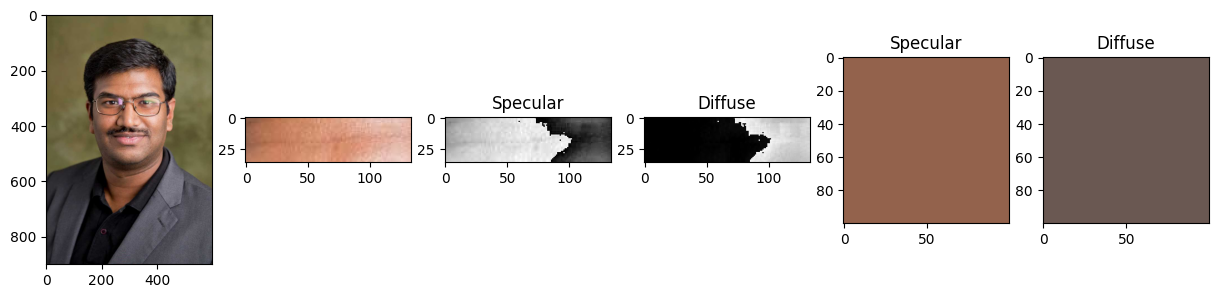

In [31]:
'''plot for debugging'''

i = 1
fig, axs = plt.subplots(1,6, figsize=(15,10))
file = df.iloc[i,:].image
img = cv2.imread(file)
imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #RGB color imag
cropped_F = imgc[df.iloc[i,:].F_1[1]:df.iloc[i,:].F_2[1], 
                 df.iloc[i,:].F_1[0]:df.iloc[i,:].F_2[0]]

W = df.iloc[i,:].W_list_F
comp = df.iloc[i,:].H_list_F
Images_NFM = np.reshape(W,(cropped_F.shape[0],cropped_F.shape[1],2))
axs[0].imshow(imgc)
axs[1].imshow(cropped_F)

#s = np.argmax(np.sum(comp, axis=1))
s = df.iloc[i,:].S_list_F
sum_s = np.sum(Images_NFM[:,:,s]) # reflectance has higher sum

if s == 1:
    sum_d = np.sum(Images_NFM[:,:,0])
elif s == 0:
    sum_d = np.sum(Images_NFM[:,:,1])
       
V1 = (int(comp[s,0]),int(comp[s,1]),int(comp[s,2]))*np.ones((100,100,3), dtype='int8')

axs[2].imshow(Images_NFM[:,:,s], cmap='gray')
axs[2].set_title('Specular')

axs[4].imshow(V1)
axs[4].set_title('Specular')

if s == 1:
    axs[3].imshow(Images_NFM[:,:,0], cmap='gray')
    axs[3].set_title('Diffuse')
    V2 = (int(comp[0,0]),int(comp[0,1]),int(comp[0,2]))*np.ones((100,100,3), dtype='int8')
    axs[5].imshow(V2)
    axs[5].set_title('Diffuse')
elif s == 0:
    axs[3].imshow(Images_NFM[:,:,1], cmap='gray')
    axs[3].set_title('Diffuse')
    V2 = (int(comp[1,0]),int(comp[1,1]),int(comp[1,2]))*np.ones((100,100,3), dtype='int8')
    axs[5].imshow(V2)
    axs[5].set_title('Diffuse')


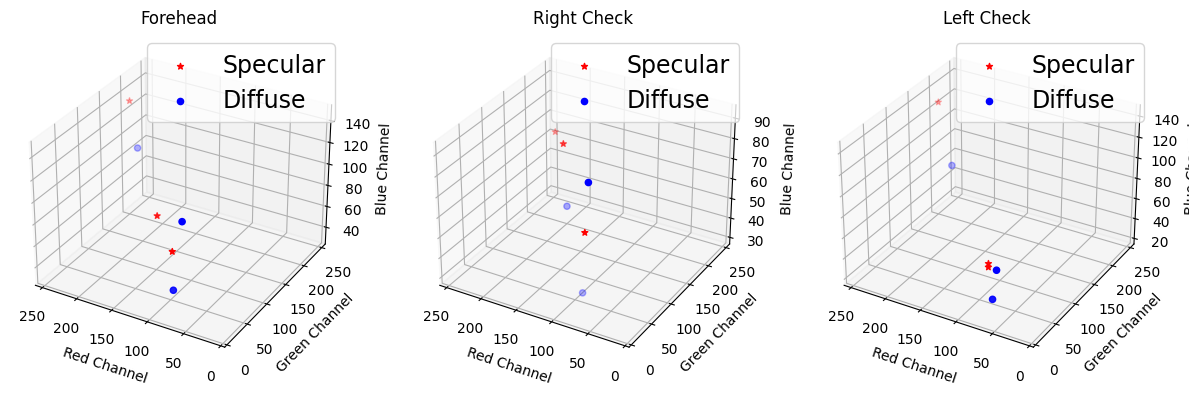

In [32]:
'''Scater plot of the Diffuse and Specular Colors'''
BIG = False
fig = plt.figure(figsize=(20,10))
 
Sp_R_F = [] 
Sp_G_F = [] 
Sp_B_F = [] 
D_R_F = [] 
D_G_F = []
D_B_F = []

Sp_R_R = []
Sp_G_R = []
Sp_B_R = []
D_R_R = []
D_G_R = []
D_B_R = []

Sp_R_L = []
Sp_G_L = []
Sp_B_L = []
D_R_L = []
D_G_L = []
D_B_L = []



for i in range(len(df)):
    comp_F = df.iloc[i,:].H_list_F
    s_F = df.iloc[i,:].S_list_F
    
    comp_R = df.iloc[i,:].H_list_R
    s_R = df.iloc[i,:].S_list_R
    
    comp_L = df.iloc[i,:].H_list_L
    s_L = df.iloc[i,:].S_list_L
    
    '''comp_A = df.iloc[i,:].H_list_A
    s_A = df.iloc[i,:].S_list_A'''
    
    Sp_R_F.append(int(comp_F[s_F,0]))
    Sp_G_F.append(int(comp_F[s_F,1]))
    Sp_B_F.append(int(comp_F[s_F,2]))
    
    Sp_R_R.append(int(comp_R[s_R,0]))
    Sp_G_R.append(int(comp_R[s_R,1]))
    Sp_B_R.append(int(comp_R[s_R,2]))
    
    Sp_R_L.append(int(comp_L[s_L,0]))
    Sp_G_L.append(int(comp_L[s_L,1]))
    Sp_B_L.append(int(comp_L[s_L,2]))

    
    if s_F == 1:
        D_R_F.append(int(comp_F[0,0]))
        D_G_F.append(int(comp_F[0,1]))
        D_B_F.append(int(comp_F[0,2]))
    elif s_F == 0:
        D_R_F.append(int(comp_F[1,0]))
        D_G_F.append(int(comp_F[1,1]))
        D_B_F.append(int(comp_F[1,2]))
                

    if s_R == 1:
        D_R_R.append(int(comp_R[0,0]))
        D_G_R.append(int(comp_R[0,1]))
        D_B_R.append(int(comp_R[0,2]))
    elif s_R == 0:
        D_R_R.append(int(comp_R[1,0]))
        D_G_R.append(int(comp_R[1,1]))
        D_B_R.append(int(comp_R[1,2]))

    if s_L == 1:
        D_R_L.append(int(comp_L[0,0]))
        D_G_L.append(int(comp_L[0,1]))
        D_B_L.append(int(comp_L[0,2]))
    elif s_L == 0:
        D_R_L.append(int(comp_L[1,0]))
        D_G_L.append(int(comp_L[1,1]))
        D_B_L.append(int(comp_L[1,2]))
        
        
            
ax = fig.add_subplot(141, projection='3d')
if BIG:
    ax.set_xlim3d([255, 0])
    ax.set_ylim3d([0, 255])
    ax.set_zlim3d([0, 255])
    ax.set_xticks(range(0,255,30))
    ax.set_yticks(range(0,255,30))
    ax.set_zticks(range(0,255,30))            
ax.scatter(Sp_R_F, Sp_G_F, Sp_B_F, c='red', label ='Specular', marker = '*')
ax.scatter(D_R_F, D_G_F, D_B_F, c='blue', label ='Diffuse', marker = 'o')
ax.legend(fontsize =17)        
ax.set_xlim3d([255, 0])
ax.set_ylim3d([0,255])
ax.set_xlabel('Red Channel')
ax.set_ylabel('Green Channel')
ax.set_zlabel('Blue Channel')
ax.set_title('Forehead')

ax = fig.add_subplot(142, projection='3d')
if BIG:
    ax.set_xlim3d([255, 0])
    ax.set_ylim3d([0, 255])
    ax.set_zlim3d([0, 255])
    ax.set_xticks(range(0,255,30))
    ax.set_yticks(range(0,255,30))
    ax.set_zticks(range(0,255,30))            
ax.scatter(Sp_R_R, Sp_G_R, Sp_B_R, c='red', label ='Specular', marker = '*')
ax.scatter(D_R_R, D_G_R, D_B_R, c='blue', label ='Diffuse', marker = 'o')
ax.legend(fontsize =17)        
ax.set_xlim3d([255, 0])
ax.set_ylim3d([0,255])
ax.set_xlabel('Red Channel')
ax.set_ylabel('Green Channel')
ax.set_zlabel('Blue Channel')
ax.set_title('Right Check')

ax = fig.add_subplot(143, projection='3d')
if BIG:
    ax.set_xlim3d([255, 0])
    ax.set_ylim3d([0, 255])
    ax.set_zlim3d([0, 255])
    ax.set_xticks(range(0,255,30))
    ax.set_yticks(range(0,255,30))
    ax.set_zticks(range(0,255,30))            
ax.scatter(Sp_R_L, Sp_G_L, Sp_B_L, c='red', label ='Specular', marker = '*')
ax.scatter(D_R_L, D_G_L, D_B_L, c='blue', label ='Diffuse', marker = 'o')
ax.legend(fontsize =17)        
ax.set_xlim3d([255, 0])
ax.set_ylim3d([0,255])
ax.set_xlabel('Red Channel')
ax.set_ylabel('Green Channel')
ax.set_zlabel('Blue Channel')
ax.set_title('Left Check')




plt.show()  

In [33]:
'''Representing boundaries of the measure'''

Specular_basis_F = []
Diffuse_basis_F = []
Sum_Diffuse_F = []
Sum_Specular_F = []

Specular_basis_R = []
Diffuse_basis_R = []
Sum_Diffuse_R = []
Sum_Specular_R = []

Specular_basis_L = []
Diffuse_basis_L = []
Sum_Diffuse_L = []
Sum_Specular_L = []


for i in tqdm(range(len(df)),position=0, leave=True):
    s = df.iloc[i,:].S_list_F # index of specular
    Specular_basis_F.append(df.iloc[i,:].H_list_F[s,:])
    Sum_Specular_F.append(np.sum(df.iloc[i,:].H_list_F[s,:]))
    if s == 1:
        Diffuse_basis_F.append(df.iloc[i,:].H_list_F[0,:])
        Sum_Diffuse_F.append(np.sum(df.iloc[i,:].H_list_F[0,:]))
    elif s == 0:
        Diffuse_basis_F.append(df.iloc[i,:].H_list_F[1,:])
        Sum_Diffuse_F.append(np.sum(df.iloc[i,:].H_list_F[1,:]))
        
    s = df.iloc[i,:].S_list_R # index of specular
    Specular_basis_R.append(df.iloc[i,:].H_list_R[s,:])
    Sum_Specular_R.append(np.sum(df.iloc[i,:].H_list_R[s,:]))
    if s == 1:
        Diffuse_basis_R.append(df.iloc[i,:].H_list_R[0,:])
        Sum_Diffuse_R.append(np.sum(df.iloc[i,:].H_list_R[0,:]))
    elif s == 0:
        Diffuse_basis_R.append(df.iloc[i,:].H_list_R[1,:])
        Sum_Diffuse_R.append(np.sum(df.iloc[i,:].H_list_R[1,:]))    
        
    s = df.iloc[i,:].S_list_L # index of specular
    Specular_basis_L.append(df.iloc[i,:].H_list_L[s,:])
    Sum_Specular_L.append(np.sum(df.iloc[i,:].H_list_L[s,:]))
    if s == 1:
        Diffuse_basis_L.append(df.iloc[i,:].H_list_L[0,:])
        Sum_Diffuse_L.append(np.sum(df.iloc[i,:].H_list_L[0,:]))
    elif s == 0:
        Diffuse_basis_L.append(df.iloc[i,:].H_list_L[1,:])
        Sum_Diffuse_L.append(np.sum(df.iloc[i,:].H_list_L[1,:]))  
        
        

df['Specular_basis_F'] = Specular_basis_F
df['Diffuse_basis_F'] = Diffuse_basis_F
df['Sum_Diffuse_F'] = Sum_Diffuse_F
df['Sum_Specular_F'] = Sum_Specular_F

df['Specular_basis_R'] = Specular_basis_R
df['Diffuse_basis_R'] = Diffuse_basis_R
df['Sum_Diffuse_R'] = Sum_Diffuse_R
df['Sum_Specular_R'] = Sum_Specular_R

df['Specular_basis_L'] = Specular_basis_L
df['Diffuse_basis_L'] = Diffuse_basis_L
df['Sum_Diffuse_L'] = Sum_Diffuse_L
df['Sum_Specular_L'] = Sum_Specular_L

100%|██████████| 3/3 [00:00<00:00, 1210.71it/s]


In [34]:
df

,image,C_R_1,C_R_2,C_L_1,C_L_2,F_1,F_2,W_list_F,H_list_F,S_list_F,Sum_S_F,Sum_D_F,Reflectance_Index_F,W_list_R,H_list_R,S_list_R,Sum_S_R,Sum_D_R,Reflectance_Index_R,W_list_L,H_list_L,S_list_L,Sum_S_L,Sum_D_L,Reflectance_Index_L,Average_Pixel_F_R,Average_Pixel_F_G,Average_Pixel_F_B,Average_Pixel_L_R,Average_Pixel_L_G,Average_Pixel_L_B,Average_Pixel_R_R,Average_Pixel_R_G,Average_Pixel_R_B,Specular_basis_F,Diffuse_basis_F,Sum_Diffuse_F,Sum_Specular_F,Specular_basis_R,Diffuse_basis_R,Sum_Diffuse_R,Sum_Specular_R,Specular_basis_L,Diffuse_basis_L,Sum_Diffuse_L,Sum_Specular_L
0,sample_images/Schuckers_Stephanie.jpg,"(1103, 1112)","(1252, 1314)","(539, 1112)","(673, 1339)","(681, 714)","(1098, 825)","[[0.0, 1.0395518977986857], [0.0, 1.0259531388...","[[199.43329978518673, 139.38643324254647, 116....",1,25728.688889,22346.246664,0.535179,"[[1.153349869747211, 0.18141723229257764], [1....","[[162.86555170560624, 110.73037622250135, 92.0...",0,14768.307613,25602.445844,0.365817,"[[0.010875220203905729, 0.9639401983803566], [...","[[182.52870355804296, 124.15067697340663, 102....",1,17003.749584,15847.547957,0.517598,222.830773,160.364357,137.652840,221.602209,156.707870,132.519232,192.589142,127.732275,99.106485,"[227.35845393060458, 167.57191856671813, 146.6...","[199.43329978518673, 139.38643324254647, 116.6...",455.506690,541.554205,"[162.86555170560624, 110.73037622250135, 92.06...","[132.19171194919957, 86.53627780573665, 63.623...",282.351291,365.664606,"[225.79077327139473, 164.8558763801455, 142.02...","[182.52870355804296, 124.15067697340663, 102.5...",409.240235,532.673551
1,sample_images/Mahesh_Banavar.jpg,"(368, 367)","(429, 432)","(184, 367)","(226, 439)","(227, 235)","(361, 271)","[[0.007049022169063997, 0.8698753570148462], [...","[[106.54950893579708, 88.50832596876343, 82.83...",1,4910.605816,2718.414445,0.643675,"[[0.0, 0.4458577644482825], [0.0, 0.4426909424...","[[101.10511606671746, 84.17954270681902, 78.90...",1,4018.962997,2121.031577,0.654555,"[[1.2153083328124317, 0.335917481295189], [1.2...","[[79.70295460773495, 55.958076616920316, 46.46...",1,2695.684826,2115.291737,0.560320,210.332090,149.759328,124.028814,138.288690,91.924272,73.375000,206.261034,153.898108,131.933165,"[147.1029992163068, 98.47914518460043, 76.5729...","[106.54950893579708, 88.50832596876343, 82.835...",277.893656,322.155115,"[149.743350013857, 107.60401617921242, 88.9413...","[101.10511606671746, 84.17954270681902, 78.909...",264.193791,346.288738,"[92.90559281475447, 58.80582852367384, 45.7221...","[79.70295460773495, 55.958076616920316, 46.463...",182.124417,197.433614
2,sample_images/Keivan_Bahmani.jpg,"(474, 412)","(544, 528)","(225, 412)","(296, 522)","(303, 234)","(498, 286)","[[1.2363460834314288, 0.08235948607431812], [1...","[[114.71094617945744, 78.44927454170626, 56.78...",0,4836.842732,10999.127907,0.305434,"[[0.0, 1.2120365219268467], [0.0, 1.2190735525...","[[99.32989999216407, 72.79448589975904, 56.964...",0,3321.904948,9251.923907,0.264192,"[[1.3416158969639171, 0.4082953167321985], [1....","[[96.08787283984731, 65.20450971809584, 45.554...",0,3518.337696,8491.155187,0.292963,162.331460,94.983531,61.442012,128.310755,74.739821,45.624712,144.319581,87.430911,58.524261,"[114.71094617945744, 78.44927454170626, 56.781...","[98.79705152645863, 53.5191274790985, 32.19360...",184.509785,249.941754,"[99.32989999216407, 72.79448589975904, 56.9647...","[90.3487697474617, 51.19833900212732, 31.78737...",173.334481,229.089143,"[96.08787283984731, 65.20450971809584, 45.5549...","[77.87907438927152, 42.038178542850744, 23.608...",143.525795,206.847338


In [36]:
'''Non negative linear modeling on non linear basis features''' 
'''Available memory may be a constraint so ramdomly sample from basis'''

df_S = df.sample(3) #as many samples as available memory will allow

dif_basis_array_F_sample = np.concatenate([df_S.Diffuse_basis_F.to_list()], axis = 1)
dif_basis_array_R_sample = np.concatenate([df_S.Diffuse_basis_R.to_list()], axis = 1)
dif_basis_array_L_sample = np.concatenate([df_S.Diffuse_basis_L.to_list()], axis = 1)


dif_basis_array_F = np.concatenate([df.Diffuse_basis_F.to_list()], axis = 1)
dif_basis_array_R = np.concatenate([df.Diffuse_basis_R.to_list()], axis = 1)
dif_basis_array_L = np.concatenate([df.Diffuse_basis_L.to_list()], axis = 1)


scaler = StandardScaler()
dif_basis_array_F =  scaler.fit_transform(dif_basis_array_F)
dif_basis_array_F_sample =  scaler.fit_transform(dif_basis_array_F_sample)

scaler = StandardScaler()
dif_basis_array_R =  scaler.fit_transform(dif_basis_array_R)
dif_basis_array_R_sample =  scaler.fit_transform(dif_basis_array_R_sample)

scaler = StandardScaler()
dif_basis_array_L =  scaler.fit_transform(dif_basis_array_L)
dif_basis_array_L_sample =  scaler.fit_transform(dif_basis_array_L_sample)


pca_F = KernelPCA(kernel="poly",  degree=3, n_components=3, fit_inverse_transform=True)
pca_F.fit(dif_basis_array_F_sample)
dif_array_pca_F = pca_F.transform(dif_basis_array_F)

pca_R = KernelPCA(kernel="poly",  degree=3, n_components=3, fit_inverse_transform=True)
pca_R.fit_transform(dif_basis_array_R_sample)
dif_array_pca_R = pca_R.transform(dif_basis_array_R)

pca_L = KernelPCA(kernel="poly",  degree=3, n_components=3, fit_inverse_transform=True)
pca_L.fit_transform(dif_basis_array_L_sample)
dif_array_pca_L = pca_L.transform(dif_basis_array_L)


scaler = StandardScaler()
df['Diffuse_First_Principal_F'] = scaler.fit_transform(dif_array_pca_F[:,0].reshape(-1, 1))
scaler = StandardScaler()
df['Diffuse_Second_Principal_F'] = scaler.fit_transform(dif_array_pca_F[:,1].reshape(-1, 1))
scaler = StandardScaler()
df['Diffuse_Third_Principal_F'] = scaler.fit_transform(dif_array_pca_F[:,2].reshape(-1, 1))

scaler = StandardScaler()
df['Diffuse_First_Principal_R'] = scaler.fit_transform(dif_array_pca_R[:,0].reshape(-1, 1))
scaler = StandardScaler()
df['Diffuse_Second_Principal_R'] = scaler.fit_transform(dif_array_pca_R[:,1].reshape(-1, 1))
scaler = StandardScaler()
df['Diffuse_Third_Principal_R'] = scaler.fit_transform(dif_array_pca_R[:,2].reshape(-1, 1))

scaler = StandardScaler()
df['Diffuse_First_Principal_L'] = scaler.fit_transform(dif_array_pca_L[:,0].reshape(-1, 1))
scaler = StandardScaler()
df['Diffuse_Second_Principal_L'] = scaler.fit_transform(dif_array_pca_L[:,1].reshape(-1, 1))
scaler = StandardScaler()
df['Diffuse_Third_Principal_L'] = scaler.fit_transform(dif_array_pca_L[:,2].reshape(-1, 1))


df['Fused_SREDS'] = df[['Diffuse_First_Principal_R','Diffuse_First_Principal_L','Diffuse_First_Principal_F']].mean(axis=1)

# SREDS value for each sample
scaler = StandardScaler()
df['Fused_SREDS'] = scaler.fit_transform(df.Fused_SREDS.to_numpy().reshape(-1, 1))


In [37]:
'''checking all black and all white patches in the direction of PC1'''
white  = (255,255,255)*np.ones((1,3), dtype='int8')
black  = np.zeros((1,3), dtype='int8')
white_pca = pca_F.transform(white)
black_pca = pca_F.transform(black)
print('all_black  '+str(black_pca[0][0]))
print('all_white '+str(white_pca[0][0]))
print('minimum Forehead skin '+str(dif_array_pca_F[:,0].min()))
print('maximum Forhead  skin '+str(dif_array_pca_F[:,0].max()))
print('______________________')
white_pca = pca_R.transform(white)
black_pca = pca_R.transform(black)
print('all_black  '+str(black_pca[0][0]))
print('all_white '+str(white_pca[0][0]))
print('minimum Right Cheek skin '+str(dif_array_pca_R[:,0].min()))
print('maximum Right Cheek  skin '+str(dif_array_pca_R[:,0].max()))
print('______________________')
white_pca = pca_L.transform(white)
black_pca = pca_L.transform(black)
print('all_black  '+str(black_pca[0][0]))
print('all_white '+str(white_pca[0][0]))
print('minimum Left Cheek skin '+str(dif_array_pca_L[:,0].min()))
print('maximum Left Cheek  skin '+str(dif_array_pca_L[:,0].max()))
print('______________________')

all_black  -0.6102556846111946
all_white 10027755.720853519
minimum Forehead skin -2.266050600567588
maximum Forhead  skin 3.110418315242071
______________________
all_black  -0.7939164528095848
all_white -8247773.958666878
minimum Right Cheek skin -1.7120951763310923
maximum Right Cheek  skin 3.0155531362371604
______________________
all_black  -1.1277207384144814
all_white 9684117.801400665
minimum Left Cheek skin -1.9637311228069947
maximum Left Cheek  skin 3.563115635721969
______________________


In [24]:
save = False

if save:
    path_to_save = '/example/path'
    df.to_pickle(path_to_save)


In [2]:
read = True

if read:
    df = pd.read_pickle('/example/path')
